In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
#import warnings
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justincrawford/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1> Yelp Review NLP Project </h1>

<p> <strong>This is a machine learning project using a dataset of yelp reviews from Kaggle. (https://www.kaggle.com/c/yelp-recsys-2013). The goal of the project is to examine and visualize the data, and train a model to predict whether a customer review is a good or bad. </strong></p>

In [33]:
reviews =  pd.read_csv('yelp.csv') 
reviews2 = pd.read_csv('new_yelp_review_2.csv', index_col=0)
#reviews2.head()
#reviews.head()
# The first data set had many more positive reviews so I am adding more negative reviews
# from a second dataset
#reviews2 = reviews2[reviews2['stars'] == 1]
reviews2 = reviews2.iloc[:3000]
reviews = reviews.append(reviews2)


<h3>Examine the head of the dataframe to get an idea of what the data consists of.</h3>

In [34]:
reviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0.0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0.0
1.0,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0.0
2.0,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0.0
3.0,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0.0
4.0,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0.0


<p><strong>The business_id, review_id, user_id, and date will not be used so those columns can be removed. I'll add a column containing the length of review in characters to have an additional feature to work with. </strong></p>

In [35]:
# add a column for review text length
reviews['length'] = reviews['text'].apply(len)

In [36]:
# drop unused data columns
reviews = reviews.drop(['review_id'], axis=1)
reviews = reviews.drop(['business_id'], axis=1)
reviews = reviews.drop(['user_id'], axis=1)
reviews = reviews.drop(['date'], axis=1)

In [37]:
reviews = reviews.drop(['type'], axis=1)
reviews.head()

,stars,text,cool,useful,funny,length
0.0,5,My wife took me here on my birthday for breakf...,2,5,0.0,889
1.0,5,I have no idea why some people give bad review...,0,0,0.0,1345
2.0,4,love the gyro plate. Rice is so good and I als...,0,1,0.0,76
3.0,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0.0,419
4.0,5,General Manager Scott Petello is a good egg!!!...,0,0,0.0,469


<h2> Analyzing the data </h2>

<h3>Examine the number of reviews for each review length.<h3>

In [38]:
# histogram showing the number of reviews for each length of text
fig = px.histogram(reviews, x="length")
fig.show()

<p> The majority of reviews are between 0 and 1000 characters


</p>

<h3> Compare length of review to star rating </h3>

In [39]:
# histograms that show the number of reviews for each length of text for each sentiment
fig = px.histogram(reviews, x="length", color='stars')
fig.show()

<p><strong>The majority of reviews for all star ratings are between 0 and 1000 characters.</strong></p>

<h3> Examine the number of star ratings for reviews in the dataset </h3>

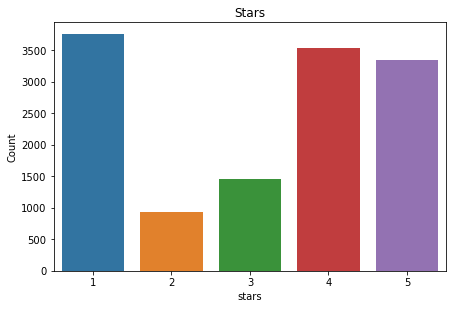

In [40]:
# countplot showing the total number of negative and positive reviews in the dataset

fig = plt.figure(figsize=(12,8))
axes1 = plt.subplot(2,2,1)
axes1 = sns.countplot(x='stars', data=reviews)
axes1.set_title('Stars')
axes1.set_ylabel('Count')
plt.tight_layout()
#ax = sns.barplot(x="stars", y="stars", data=reviews, estimator=lambda x: len(x) / len(reviews) * 100)
#ax.set(ylabel="Percent")

<p> <strong>The data contains many 1 star reviews and 4-5 star reviews. </stong></p> 

<h3> Display the frequency of each review length </h3>

Text(0, 0.5, 'Density')

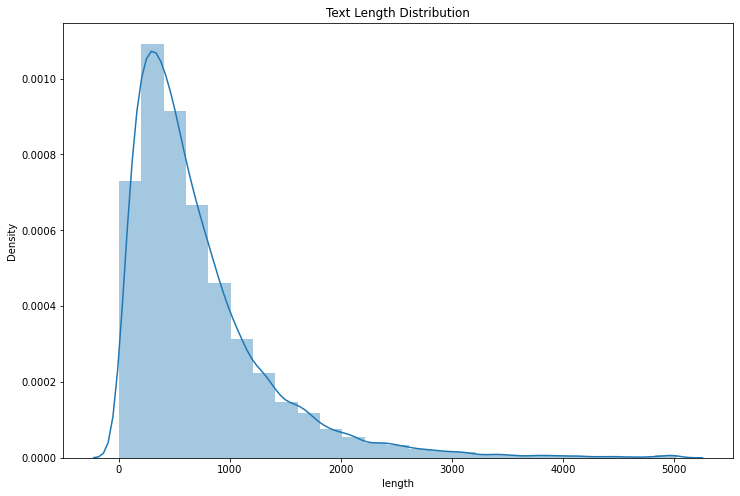

In [41]:
# graph of the distribution of text length
length_distro = plt.figure(figsize=(12,8))
sns.distplot(reviews['length'], kde=True, bins=25)
plt.title('Text Length Distribution')
plt.ylabel('Density')

<h3>A heatmap to examine if there is any correlation between the columns of the dataset</h3>


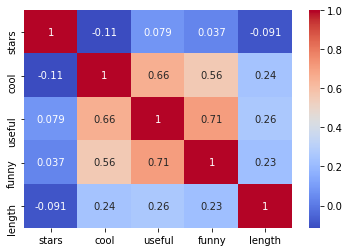

In [42]:
#stars = reviews.groupby('stars').mean()


# heatmap to look for categories that may have a correlation
#stars.corr()

#sns.heatmap(stars.corr(),cmap='coolwarm',annot=True)
sns.heatmap(reviews.corr(), cmap='coolwarm', annot=True)

<p><strong> The columns in the data that correlate the most are 'cool' and a 'funny'. Since these columns are basically a rating of the review itself, this correlation will not help identify positive or negative reviews. It appears that no columns have much correlation with the star rating. </strong></p>

<p><strong> For the remainder of the analysis we are going to work with only the 1 star reviews and the 5 star reviews</strong></p>

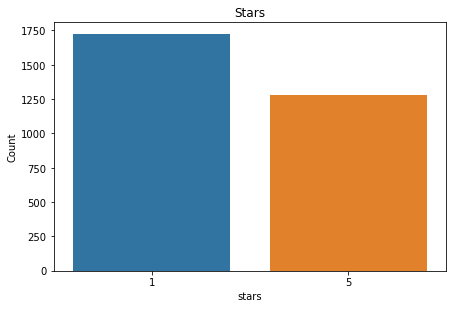

In [43]:

reviews_class = reviews[(reviews.stars==1) | (reviews.stars==5)]
reviews_class = reviews_class.iloc[2500:5500]
fig = plt.figure(figsize=(12,8))
axes1 = plt.subplot(2,2,1)
axes1 = sns.countplot(x='stars', data=reviews_class)
axes1.set_title('Stars')
axes1.set_ylabel('Count')
plt.tight_layout()


<h3> Descriptive Method - K-means Clustering </h3>

<p><strong>I attempt to use k-means clustering to find relationships within the text data.
   The review text is transformed using TFIDF (term frequency inverse document frequency).
    Since we are trying to classify positive and negative reviews 2 clusters will used</strong><p>

In [44]:
# Preparing the text data to attemp k-means clustering
random_state = 0
vector = TfidfVectorizer(stop_words="english")
vector.fit(reviews_class.text.values)
features = vector.transform(reviews_class.text.values)

In [45]:
clusters = MiniBatchKMeans(n_clusters=2, random_state=random_state)
clusters.fit(features)

MiniBatchKMeans(n_clusters=2, random_state=0)

In [46]:
# add a column to the dataframe to hold the cluster label
#warnings.filterwarnings("ignore")
reviews_class['cluster_num'] = clusters.labels_

In [47]:
# convert the feature dimension into two dimensions for plotting
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())
reduced_cluster_centers = pca.transform(clusters.cluster_centers_)

<p> <strong>Below is a scatterplot to show the result of clustering.</strong> </p>

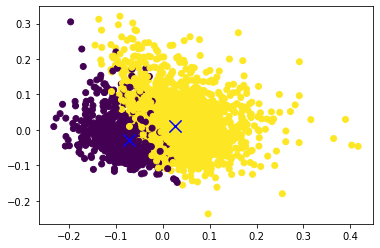

In [48]:
# plot the results of k-means clustering
plt.scatter(reduced_features[:,0], reduced_features[:,1], c = clusters.predict(features))
plt.scatter(reduced_cluster_centers[:,0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

<p> <strong>The scatterplot show a lot of overlap in the clusters. Below is homogeneity_score of 
    the clustering results</strong> </p>

In [49]:
# Evaluate the results of k-means clustering
from sklearn.metrics import homogeneity_score
homogeneity_score(reviews_class.stars, clusters.predict(features))

0.16616185236224035

<p> <strong>Ideally a score close to 1 would show effective clustering. The score for the review text
    is close to zero which confirms a lot of overlap in the clusters. Probably because both 
    positive and negative reviews share many common words.</strong> </p>
    
<p> <strong>Below we can look at some wordclouds from each cluster to see what kind of words were placed
    in the clusters </strong></p>

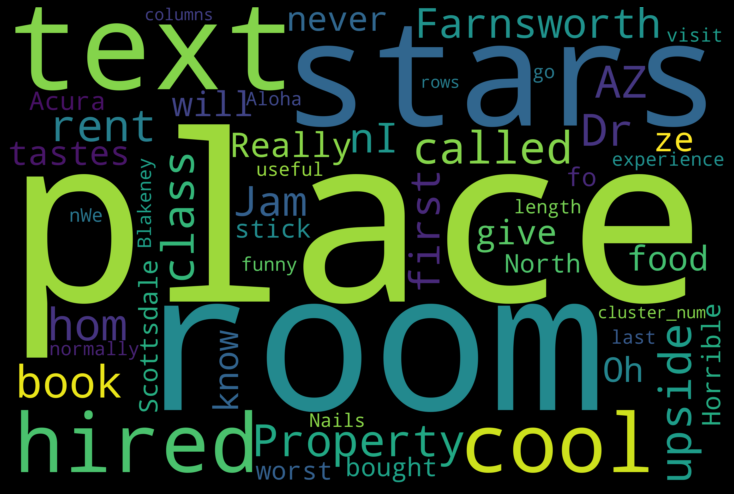

In [50]:
#warnings.filterwarnings("ignore")
reviews_cluster_0 = reviews_class[reviews_class['cluster_num'] == 0] 
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(reviews_cluster_0))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

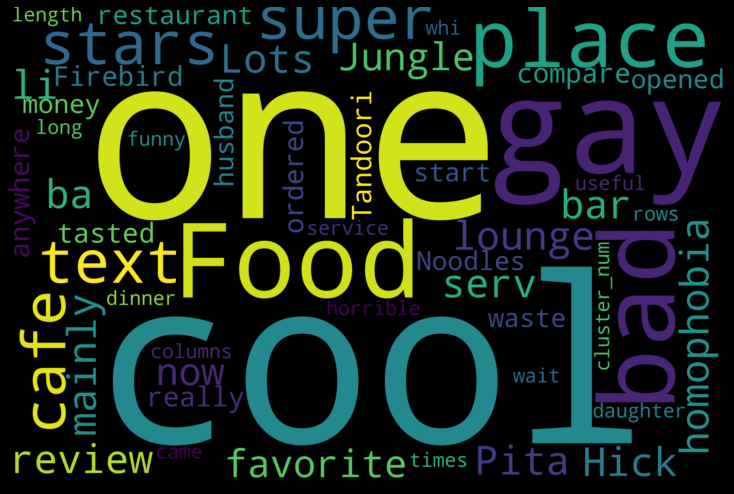

In [51]:
#warnings.filterwarnings("ignore")
reviews_cluster_1 = reviews_class[reviews_class['cluster_num'] == 1] 
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(reviews_cluster_1))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

<p><strong> Clustering did not provide much usefulness predicting what text would make a good
    or bad review </strong></p>

<h3> Non-Descriptive Method - Multinomial Naive Bayes </h3>

<p><strong> Naive Bayes is a popular classification algorithm for use with NLP projects and is often used in spam filtering. I     Will split the data and use 30% for training and remaining 70% for testing.</strong></p>

In [52]:
from sklearn.metrics import confusion_matrix,classification_report


In [53]:
# function to clean the text of punctuation and stopwords
def clean_text(text):
    remove_punctuation = [word for word in text if word not in string.punctuation]
    remove_punctuation = ''.join(remove_punctuation)
    return [word.lower() for word in remove_punctuation.split() if word.lower() not in stopwords.words('english')]
   

In [54]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  # strings to token integer counts
    #('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [55]:
X = reviews_class['text']
y = reviews_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=101)

In [56]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function clean_text at 0x7fa6d7ecb670>)),
                ('classifier', MultinomialNB())])

In [57]:
predictions = pipeline.predict(X_test)

In [58]:
print('Confusion Matrix')
labels = np.unique(y_test)
#print(confusion_matrix(y_test,predictions, labels=labels))
a = confusion_matrix(y_test, predictions, labels=labels)
print(pd.DataFrame(a, index=labels, columns=labels))
print('\n')
print('classification report')


print(classification_report(y_test,predictions))

Confusion Matrix
     1    5
1  314   25
5   31  230


classification report
              precision    recall  f1-score   support

           1       0.91      0.93      0.92       339
           5       0.90      0.88      0.89       261

    accuracy                           0.91       600
   macro avg       0.91      0.90      0.90       600
weighted avg       0.91      0.91      0.91       600



In [59]:
print(pipeline.predict(["Starbucks is trash... Why do people go to this overpriced steaming pile of garbage coffee shop. I can make some Foldgers instand blend at home that cost me .10 and tastes better.",
                       "What a great resturaunt with awesome food and service"]))

[1 5]


In [60]:
import ipywidgets as widgets
from ipywidgets import interact

In [61]:
def get_review(x):
    review_list = []
    review_list.append(x)
    if pipeline.predict(review_list) == 5:
        print('\033[1m{:10s}\033[0m'.format('It was a good review!'))
        #print("it was a good review")
    else:
       print('\033[1m{:10s}\033[0m'.format('It was a bad review!'))

In [62]:
print(interact(get_review, x = 'insert review here'))

interactive(children=(Text(value='insert review here', description='x'), Output()), _dom_classes=('widget-inte…

<function get_review at 0x7fa5ac6b3f70>
